## Import Dependencies

In [1]:
#data preprocessing
import pandas as pd
#produces a prediction model in the form of an ensemble of weak prediction models, typically decision tree
import xgboost as xgb
#the outcome (dependent variable) has only a limited number of possible values. 
#Logistic Regression is used when response variable is categorical in nature.
from sklearn.linear_model import LogisticRegression
#A random forest is a meta estimator that fits a number of decision tree classifiers 
#on various sub-samples of the dataset and use averaging to improve the predictive 
#accuracy and control over-fitting.
from sklearn.ensemble import RandomForestClassifier
#a discriminative classifier formally defined by a separating hyperplane.
from sklearn.svm import SVC
#displayd data
from IPython.display import display
%matplotlib inline

In [2]:
# Read data and drop redundant column.
loc = "C:/Users/hsanb/Desktop/Datasets/"
data = pd.read_csv(loc+'final_dataset.csv')

# Preview data.
display(data.head())


#Full Time Result (H=Home Win, D=Draw, A=Away Win)
#HTGD - Home team goal difference
#ATGD - away team goal difference
#HTP - Home team points
#ATP - Away team points
#DiffFormPts Diff in points
#DiffLP - Differnece in last years prediction

#Input - 12 other features (fouls, shots, goals, misses,corners, red card, yellow cards)
#Output - Full Time Result (H=Home Win, D=Draw, A=Away Win) 

,Unnamed: 0,FTR,HTHG,HTAG,HS,AS,HST,AST,HF,AF,...,HTLossStreak5,ATWinStreak3,ATWinStreak5,ATLossStreak3,ATLossStreak5,HTGD,ATGD,DiffPts,DiffFormPts,DiffLP
0,0,D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,4.0
1,1,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0.0,0.0,-3.0,0.0,1.0
2,2,D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0
3,3,D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,-9.0
4,4,D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,2.0


In [3]:
data.drop('Unnamed: 0',axis=1, inplace=True)

## Data Exploration

In [4]:
#what is the win rate for the home team?

# Total number of matches.
n_matches = data.shape[0]

# Calculate number of features. -1 because we are saving one as the target variable (win/lose/draw)
n_features = data.shape[1] - 1

# Calculate matches won by home team.
n_homewins = len(data[data.FTR == 'H'])

# Calculate win rate for home team.
win_rate = (float(n_homewins) / (n_matches)) * 100

# Print the results
print ("Total number of matches: ",n_matches)
print ("Number of features: ",n_features)
print ("Number of matches won by home team: ",n_homewins)
print("Win rate of home team: %.2f "%(win_rate))


Total number of matches:  5433
Number of features:  54
Number of matches won by home team:  2522
Win rate of home team: 46.42 


"['MW', 'FTHG', 'FTAG', 'FTR', 'DC', 'HTWinStreak3', 'HTWinStreak5',\n       'HTLossStreak3', 'HTLossStreak5', 'ATWinStreak3', 'ATWinStreak5',\n       'ATLossStreak3', 'ATLossStreak5', 'HTGD', 'ATGD', 'DiffPts',\n       'DiffFormPts', 'DiffLP']"

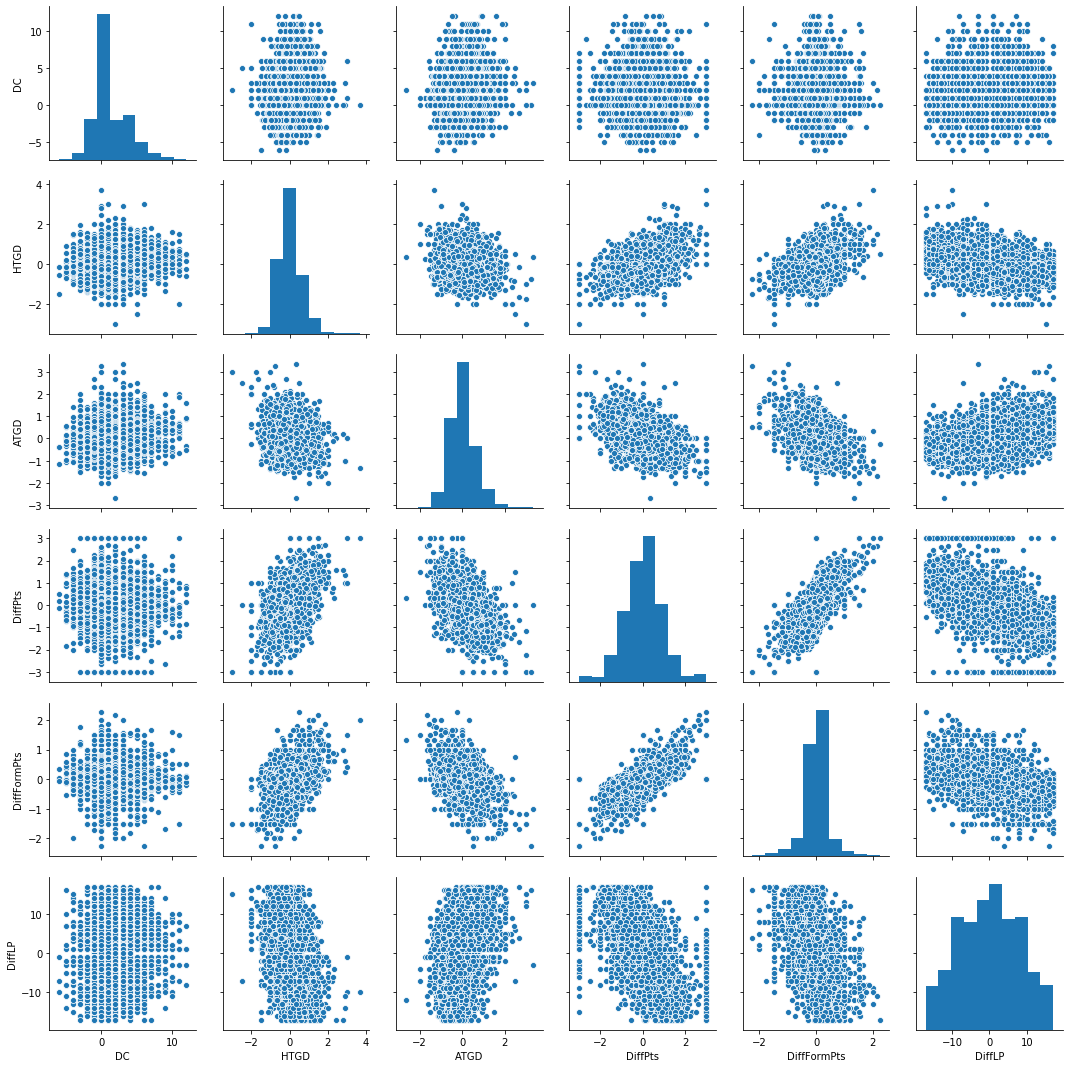

In [5]:
# Visualising distribution of data
import seaborn as sns
import matplotlib.pyplot as plt
#the scatter matrix is plotting each of the columns specified against each other column.
#You would have observed that the diagonal graph is defined as a histogram, which means that in the 
#section of the plot matrix where the variable is against itself, a histogram is plotted.

#Scatter plots show how much one variable is affected by another. 
#The relationship between two variables is called their correlation
#negative vs positive correlation

#HTGD - Home team goal difference
#ATGD - away team goal difference
#HTP - Home team points
#ATP - Away team points
#DiffFormPts Diff in points
#DiffLP - Differnece in last years prediction

sns.pairplot(data[['DC','HTGD','ATGD', 'DiffPts','DiffFormPts','DiffLP']])

'''['MW', 'FTHG', 'FTAG', 'FTR', 'DC', 'HTWinStreak3', 'HTWinStreak5',
       'HTLossStreak3', 'HTLossStreak5', 'ATWinStreak3', 'ATWinStreak5',
       'ATLossStreak3', 'ATLossStreak5', 'HTGD', 'ATGD', 'DiffPts',
       'DiffFormPts', 'DiffLP']'''


In [6]:
data

,FTR,HTHG,HTAG,HS,AS,HST,AST,HF,AF,HC,...,HTLossStreak5,ATWinStreak3,ATWinStreak5,ATLossStreak3,ATLossStreak5,HTGD,ATGD,DiffPts,DiffFormPts,DiffLP
0,D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,4.0
1,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0.000000,0.000000,-3.000000,0.000000,1.0
2,D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,1.0
3,D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,-9.0
4,D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5428,NaN,1.0,1.0,16.0,9.0,10.0,4.0,17.0,13.0,4.0,...,0,0,0,0,0,-0.434783,-0.217391,-0.130435,0.260870,9.0
5429,NaN,0.0,1.0,7.0,14.0,2.0,6.0,6.0,7.0,3.0,...,0,0,0,0,0,0.391304,-0.217391,-0.260870,-0.260870,2.0
5430,NaN,1.0,2.0,5.0,18.0,1.0,8.0,12.0,7.0,2.0,...,0,0,0,0,0,-0.478261,0.391304,-0.565217,-0.260870,10.0
5431,NaN,0.0,1.0,7.0,5.0,2.0,5.0,4.0,9.0,3.0,...,0,0,0,0,0,-0.304348,0.869565,-0.913043,-0.130435,6.0


## Preparing the Data

In [7]:
data.iloc[:1000].isnull().sum().sum()

0

In [8]:
data.isnull().sum().sum()

10

In [9]:
# Separate into feature set and target variable
#FTR = Full Time Result (H=Home Win, D=Draw, A=Away Win)
X_all = data.drop(['FTR'],1)
y_all = data['FTR']

# Standardising the data.
from sklearn.preprocessing import scale

#Center to the mean and component wise scale to unit variance.
#cols = [['DC','HTGD','ATGD','HTP','ATP','DiffLP']]
cols = [['DC', 'MW', 'HTGD', 'ATGD',
        'DiffLP', 'DiffPts', 'DiffFormPts', 'HTWinStreak3', 'HTWinStreak5', 
         'HTLossStreak3', 'HTLossStreak5', 'ATWinStreak3','ATWinStreak5', 'ATLossStreak3', 'ATLossStreak5']]
for col in cols:
    X_all[col] = scale(X_all[col])
    

In [10]:
X_all.head()
#last 3 wins for both sides
X_all.HM1 = X_all.HM1.astype('str')
X_all.HM2 = X_all.HM2.astype('str')
X_all.HM3 = X_all.HM3.astype('str')
X_all.AM1 = X_all.AM1.astype('str')
X_all.AM2 = X_all.AM2.astype('str')
X_all.AM3 = X_all.AM3.astype('str')

In [11]:

#we want continous vars that are integers for our input data, so lets remove any categorical vars
def preprocess_features(X):
    ''' Preprocesses the football data and converts catagorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix = col)
                    
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print ("Processed feature columns (%5.d total features):\n "%(len(X_all.columns)))
print(list(X_all.columns))

Processed feature columns (   84 total features):
 
['HTHG', 'HTAG', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA', 'MW', 'HM1_D', 'HM1_L', 'HM1_M', 'HM1_W', 'AM1_D', 'AM1_L', 'AM1_M', 'AM1_W', 'HM2_D', 'HM2_L', 'HM2_M', 'HM2_W', 'AM2_D', 'AM2_L', 'AM2_M', 'AM2_W', 'HM3_D', 'HM3_L', 'HM3_M', 'HM3_W', 'AM3_D', 'AM3_L', 'AM3_M', 'AM3_W', 'HM4_D', 'HM4_L', 'HM4_M', 'HM4_W', 'AM4_D', 'AM4_L', 'AM4_M', 'AM4_W', 'HM5_D', 'HM5_L', 'HM5_M', 'HM5_W', 'AM5_D', 'AM5_L', 'AM5_M', 'AM5_W', 'DC', 'HTWinStreak3', 'HTWinStreak5', 'HTLossStreak3', 'HTLossStreak5', 'ATWinStreak3', 'ATWinStreak5', 'ATLossStreak3', 'ATLossStreak5', 'HTGD', 'ATGD', 'DiffPts', 'DiffFormPts', 'DiffLP']


In [12]:
# Show the feature information by printing the first five rows
print("\nFeature values:")
display(X_all)


Feature values:


,HTHG,HTAG,HS,AS,HST,AST,HF,AF,HC,AC,...,HTLossStreak5,ATWinStreak3,ATWinStreak5,ATLossStreak3,ATLossStreak5,HTGD,ATGD,DiffPts,DiffFormPts,DiffLP
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.123022,-0.269547,-0.143085,-0.244303,-0.107441,0.017541,-0.021308,-0.019227,0.038641,0.496956
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.123022,-0.269547,-0.143085,-0.244303,-0.107441,0.017541,-0.021308,-3.279004,0.038641,0.125043
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.123022,-0.269547,-0.143085,-0.244303,-0.107441,0.017541,-0.021308,-0.019227,0.038641,0.125043
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.123022,-0.269547,-0.143085,-0.244303,-0.107441,0.017541,-0.021308,-0.019227,0.038641,-1.114666
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.123022,-0.269547,-0.143085,-0.244303,-0.107441,0.017541,-0.021308,-0.019227,0.038641,0.249014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5428,1.0,1.0,16.0,9.0,10.0,4.0,17.0,13.0,4.0,5.0,...,-0.123022,-0.269547,-0.143085,-0.244303,-0.107441,-0.725963,-0.393273,-0.160956,0.673001,1.116811
5429,0.0,1.0,7.0,14.0,2.0,6.0,6.0,7.0,3.0,4.0,...,-0.123022,-0.269547,-0.143085,-0.244303,-0.107441,0.686695,-0.393273,-0.302685,-0.595720,0.249014
5430,1.0,2.0,5.0,18.0,1.0,8.0,12.0,7.0,2.0,10.0,...,-0.123022,-0.269547,-0.143085,-0.244303,-0.107441,-0.800313,0.648229,-0.633387,-0.595720,1.240782
5431,0.0,1.0,7.0,5.0,2.0,5.0,4.0,9.0,3.0,2.0,...,-0.123022,-0.269547,-0.143085,-0.244303,-0.107441,-0.502912,1.466551,-1.011333,-0.278540,0.744898


In [13]:
from sklearn.model_selection import train_test_split

# Shuffle and split the dataset into training and testing set.
'''X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
                                                    test_size = 50,
                                                    random_state = 2,
                                                    stratify = y_all)
'''

'X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, \n                                                    test_size = 50,\n                                                    random_state = 2,\n                                                    stratify = y_all)\n'

In [14]:
X_train = X_all[:5320]
y_train = y_all[:5320]

X_test = X_all[5320:(len(X_all)-10)]
y_test = y_all[5320:(len(X_all)-10)]

XX_test=X_all[(len(X_all)-10):]

In [15]:
X_train.isnull().sum().sum()

0

## Training and Evaluating Models

In [16]:
#for measuring training time
from time import time 
# F1 score (also F-score or F-measure) is a measure of a test's accuracy. 
#It considers both the precision p and the recall r of the test to compute 
#the score: p is the number of correct positive results divided by the number of 
#all positive results, and r is the number of correct positive results divided by 
#the number of positive results that should have been returned. The F1 score can be 
#interpreted as a weighted average of the precision and recall, where an F1 score 
#reaches its best value at 1 and worst at 0.
from sklearn.metrics import f1_score

def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print("Trained model in %.4f seconds"%(end - start))

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    from sklearn.metrics import    classification_report, confusion_matrix
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    
    end = time()
    # Print and return results
    print ("Made predictions in %.4f seconds."%(end - start))
    
    if(target.empty):
        return y_pred
    else:
        return classification_report(target, y_pred), confusion_matrix(target, y_pred)


def train_predict(clf, X_train, y_train):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print ("Training a %s using a training set size of %d. . ."%(clf.__class__.__name__, len(X_train)))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    f1, f2 = predict_labels(clf, X_train, y_train)
    
    print ("Classification report for training set:\n ",f1)
    print("confusion matrix for training set:\n ",f2)
def test_predict(clf, X_test, y_test):   
    if(y_test.empty):
        return predict_labels(clf, X_test, y_test)
    else:
        f1, f2 = predict_labels(clf, X_test, y_test)
        print ("Classification report for test set:\n ",f1)
        print("confusion matrix for test set:\n ",f2)

In [17]:
# Initialize the three models (XGBoost is initialized later)
clf_A = LogisticRegression(random_state = 42)
clf_B = SVC(random_state = 912, kernel='rbf')
#Boosting refers to this general problem of producing a very accurate prediction rule 
#by combining rough and moderately inaccurate rules-of-thumb
clf_C = xgb.XGBClassifier(seed = 82)

train_predict(clf_A, X_train, y_train)
test_predict(clf_A, X_test, y_test)
print('')
train_predict(clf_B, X_train, y_train)
test_predict(clf_B, X_test, y_test)
print ('')
train_predict(clf_C, X_train, y_train)
test_predict(clf_C, X_test, y_test)
print ('')

Training a LogisticRegression using a training set size of 5320. . .


C:\Users\hsanb\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\hsanb\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Trained model in 0.4138 seconds
Made predictions in 0.0040 seconds.
Classification report for training set:
                precision    recall  f1-score   support

           A       0.61      0.73      0.66      1531
           D       0.66      0.12      0.20      1313
           H       0.65      0.86      0.74      2476

    accuracy                           0.64      5320
   macro avg       0.64      0.57      0.54      5320
weighted avg       0.64      0.64      0.59      5320

confusion matrix for training set:
  [[1113   40  378]
 [ 396  155  762]
 [ 309   41 2126]]
Made predictions in 0.0010 seconds.
Classification report for test set:
                precision    recall  f1-score   support

           A       0.67      0.59      0.63        37
           D       0.33      0.05      0.09        20
           H       0.63      0.91      0.74        46

    accuracy                           0.63       103
   macro avg       0.54      0.52      0.49       103
weighted avg     

C:\Users\hsanb\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Trained model in 2.7606 seconds
Made predictions in 1.7284 seconds.
Classification report for training set:
                precision    recall  f1-score   support

           A       0.84      0.80      0.82      1531
           D       0.97      0.44      0.61      1313
           H       0.74      0.97      0.84      2476

    accuracy                           0.79      5320
   macro avg       0.85      0.74      0.75      5320
weighted avg       0.82      0.79      0.77      5320

confusion matrix for training set:
  [[1227   15  289]
 [ 164  580  569]
 [  76    5 2395]]
Made predictions in 0.0330 seconds.
Classification report for test set:
                precision    recall  f1-score   support

           A       0.61      0.46      0.52        37
           D       0.67      0.10      0.17        20
           H       0.58      0.91      0.71        46

    accuracy                           0.59       103
   macro avg       0.62      0.49      0.47       103
weighted avg     

In [18]:
# TODO: Import 'GridSearchCV' and 'make_scorer'
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


# TODO: Create the parameters list you wish to tune
parameters = { 'learning_rate' : [0.1],
               'n_estimators' : [40],
               'max_depth': [3],
               'min_child_weight': [3],
               'gamma':[0.4],
               'subsample' : [0.8],
               'colsample_bytree' : [0.8],
               'scale_pos_weight' : [1],
               'reg_alpha':[1e-5]
             }  

# TODO: Initialize the classifier
clf = xgb.XGBClassifier(seed=2)



# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf,
                        param_grid=parameters,
                        cv=5)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train,y_train)

# Get the estimator
clf = grid_obj.best_estimator_
print(clf)

# Report the final F1 score for training and testing after parameter tuning
f1, f2 = predict_labels(clf, X_train, y_train)
print ("Classification report for training set:\n ",f1)
print("confusion matrix for training set:\n ",f2)  
f1, f2 = predict_labels(clf, X_test, y_test)
print ("Classification report for test set:\n ",f1)
print("confusion matrix for test set:\n ",f2)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.4,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=3, missing=None, n_estimators=40, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1, seed=2,
              silent=None, subsample=0.8, verbosity=1)
Made predictions in 0.0330 seconds.
Classification report for training set:
                precision    recall  f1-score   support

           A       0.63      0.71      0.67      1531
           D       0.71      0.15      0.24      1313
           H       0.65      0.88      0.75      2476

    accuracy                           0.65      5320
   macro avg       0.67      0.58      0.55      5320
weighted avg       0.66      0.65      0.60      5320

confusion matrix for training set:
  [[1084   40  407]
 [ 361  191

In [19]:
#prediction

Possible Improvements?

-Adding Sentiment from Twitter, News Articles
-More features from other data sources (how much did others bet, player specific health stats)


In [20]:
y_pred=predict_labels(clf_A, XX_test, pd.Series([]))

Made predictions in 0.0000 seconds.


In [21]:
print('y_pred=\n',y_pred)

y_pred=
 ['A' 'H' 'H' 'H' 'A' 'A' 'A' 'D' 'A' 'H']


In [45]:
y_pred=predict_labels(clf_B, XX_test, pd.Series([]))
print('y_pred=\n',y_pred)

Made predictions in 0.0050 seconds.
y_pred=
 ['A' 'H' 'H' 'H' 'H' 'H' 'A' 'A' 'H' 'H']


In [22]:
y_pred=predict_labels(clf_C, XX_test, pd.Series([]))
print('y_pred=\n',y_pred)

Made predictions in 0.0020 seconds.
y_pred=
 ['H' 'D' 'H' 'H' 'H' 'A' 'A' 'A' 'A' 'H']


In [23]:
y_pred=predict_labels(clf, XX_test, pd.Series([]))
print('y_pred=\n',y_pred)

Made predictions in 0.0020 seconds.
y_pred=
 ['A' 'H' 'H' 'H' 'H' 'A' 'D' 'A' 'A' 'H']


In [24]:
import tensorflow as tf
from tensorflow import keras
import numpy as np



In [25]:
yy_train=np.zeros((y_train.shape[0],3))
for i in range(y_train.shape[0]):
    indix=(0*(y_train[i]=='H') + 1*(y_train[i]=='D') + 2*(y_train[i]=='A'))
    yy_train[i][indix]=1
    
y_train=yy_train

In [52]:

model = keras.Sequential()

model.add(keras.layers.Dense(X_train.shape[1], activation='sigmoid', input_dim=X_train.shape[1]))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(y_train.shape[1], activation='sigmoid'))

model.compile(optimizer="sgd", loss="binary_crossentropy",metrics=["accuracy"])

In [53]:
model.fit(X_train, y_train, epochs=5, batch_size=1000)


Train on 5320 samples
Epoch 1/5
5320/5320 [==============================] - 0s 23us/sample - loss: 0.7084 - accuracy: 0.5359
Epoch 2/5
5320/5320 [==============================] - 0s 4us/sample - loss: 0.6850 - accuracy: 0.5927
Epoch 3/5
5320/5320 [==============================] - 0s 4us/sample - loss: 0.6703 - accuracy: 0.6224
Epoch 4/5
5320/5320 [==============================] - 0s 4us/sample - loss: 0.6596 - accuracy: 0.6419
Epoch 5/5
5320/5320 [==============================] - 0s 4us/sample - loss: 0.6548 - accuracy: 0.6524


In [54]:
preds = model.predict(XX_test)
preds.shape

(10, 3)

In [55]:
y_pred=[]
for i in range(preds.shape[0]):
    x=np.where(preds[i]==preds[i].max())[0][0]
    y_pred.append('H'*(x==0) + 'D'*(x==1) + 'A'*(x==2))
print( type(y_pred))
print( type(y_test))

<class 'list'>
<class 'pandas.core.series.Series'>


C:\Users\hsanb\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  after removing the cwd from sys.path.


In [56]:
#y_test=list(y_test)
y_pred=pd.Series(y_pred)

In [57]:
from sklearn.metrics import classification_report, confusion_matrix

In [60]:
#classification_report(y_test,y_pred)

In [61]:
#confusion_matrix(y_test, y_pred)

In [62]:
y_pred

0    H
1    H
2    D
3    D
4    D
5    H
6    D
7    H
8    H
9    H
dtype: object